In [27]:
# Making imports convenient
import sys
import os
PATH=os.getcwd().split('/notebooks')[0]
sys.path.insert(1, PATH)

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from datasets import load_dataset, Dataset
import transformers
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, DataCollatorWithPadding,RobertaForSequenceClassification,AdamW,get_scheduler,TrainingArguments,Trainer

from src.utils.myutils import *


device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

DATA_PATH = PATH + '/data/CS/processed/WIKI-CS'

model_checkpoint = 'ufal/robeczech-base'
BATCH_SIZE = 32
transformers.utils.logging.set_verbosity_error()


## Data

In [34]:
train = load_dataset('csv',data_files=DATA_PATH+"/train.csv")['train']
dev = load_dataset('csv',data_files=DATA_PATH+"/dev.csv")['train']
babe_cs = load_dataset('csv',data_files=PATH + '/data/CS/processed/BABE/babe_sg2_cs.csv')['train']
test = load_dataset('csv',data_files=DATA_PATH+"/test.csv")['train']

Using custom data configuration default-56c437b671b1e68a
Reusing dataset csv (/home/horyctom/.cache/huggingface/datasets/csv/default-56c437b671b1e68a/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)
Using custom data configuration default-a78c926da49a5a4e
Reusing dataset csv (/home/horyctom/.cache/huggingface/datasets/csv/default-a78c926da49a5a4e/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)
Using custom data configuration default-a2670560b441305b
Reusing dataset csv (/home/horyctom/.cache/huggingface/datasets/csv/default-a2670560b441305b/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)
Using custom data configuration default-8ec62ab79f9b4092
Reusing dataset csv (/home/horyctom/.cache/huggingface/datasets/csv/default-8ec62ab79f9b4092/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff)


## Training

In [3]:
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint, use_fast=False,padding=True) #fast tokenizer is buggy in RoBERTa models
model = RobertaForSequenceClassification.from_pretrained(model_checkpoint)
model.to(device);

In [8]:
tokenize = lambda data : tokenizer(data['sentence'], truncation=True)

In [9]:
tokenized_data = babe_cs.map(tokenize,batched=True)
tokenized_data = tokenized_data.remove_columns(['sentence'])
tokenized_data.set_format("torch")

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/4 [00:00<?, ?ba/s]

In [7]:
training_args = TrainingArguments(
    num_train_epochs=10,
    per_device_train_batch_size=BATCH_SIZE,  
    #per_device_eval_batch_size=BATCH_SIZE,
    logging_steps=50,
    disable_tqdm = False,
    warmup_steps=50,
    save_total_limit=2,
    #load_best_model_at_end=True,
    #evaluation_strategy="steps",
    metric_for_best_model = 'f1',
    weight_decay=0.05,
    output_dir = './',
    learning_rate=4e-5)

## BEST PARAMS

In [35]:
train_tokenized = preprocess_data(train,tokenizer,'sentence')
test_tokenized = preprocess_data(test,tokenizer,'sentence')
dev_tokenized = preprocess_data(dev,tokenizer,'sentence')
babe_tokenized = preprocess_data(babe_cs,tokenizer,'sentence')

Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/csv/default-56c437b671b1e68a/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-1f2b8795b4b8ba57.arrow
Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/csv/default-8ec62ab79f9b4092/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-b1c66b7a047f871b.arrow
Loading cached processed dataset at /home/horyctom/.cache/huggingface/datasets/csv/default-a78c926da49a5a4e/0.0.0/9144e0a4e8435090117cea53e6c7537173ef2304525df4a077c435d8ee7828ff/cache-832112aa454ec1f8.arrow


  0%|          | 0/4 [00:00<?, ?ba/s]

In [8]:
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [9]:
model = RobertaForSequenceClassification.from_pretrained(model_checkpoint);
trainer = Trainer(model,training_args,train_dataset=train_tokenized,data_collator=data_collator,
                      tokenizer=tokenizer)
trainer.train()

***** Running training *****
  Num examples = 12368
  Num Epochs = 10
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 3870


Step,Training Loss
50,0.694500
100,0.693400
150,0.700100
200,0.685000
250,0.682200
300,0.679000
350,0.671600
400,0.691100
450,0.645100
500,0.645100


Saving model checkpoint to ./checkpoint-500
Configuration saved in ./checkpoint-500/config.json
Model weights saved in ./checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-500/tokenizer_config.json
Special tokens file saved in ./checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./checkpoint-1000
Configuration saved in ./checkpoint-1000/config.json
Model weights saved in ./checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./checkpoint-1500
Configuration saved in ./checkpoint-1500/config.json
Model weights saved in ./checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./checkpoint-1500/special_tokens_map.json
Deleting older checkpoint [checkpoint-500] due to args.save_total_limit
Saving model checkpoint to ./checkpo

TrainOutput(global_step=3870, training_loss=0.3913927850797195, metrics={'train_runtime': 762.3266, 'train_samples_per_second': 162.24, 'train_steps_per_second': 5.077, 'total_flos': 5038264265765760.0, 'train_loss': 0.3913927850797195, 'epoch': 10.0})

In [41]:
test_dataloader = DataLoader(test_tokenized, batch_size=BATCH_SIZE, collate_fn=data_collator)

In [42]:
compute_metrics(model,device,test_dataloader)

{'f1': 0.5614489003880984}

In [30]:
preds = torch.Tensor([]).to(device)

model.eval()
for batch in test_dataloader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
        outputs = model(**batch)

    logits = outputs.logits
    preds = torch.cat((preds,logits),0)

tensor([1, 0, 0,  ..., 1, 1, 0])

Confusion matrix, without normalization
[[428 355]
 [323 440]]


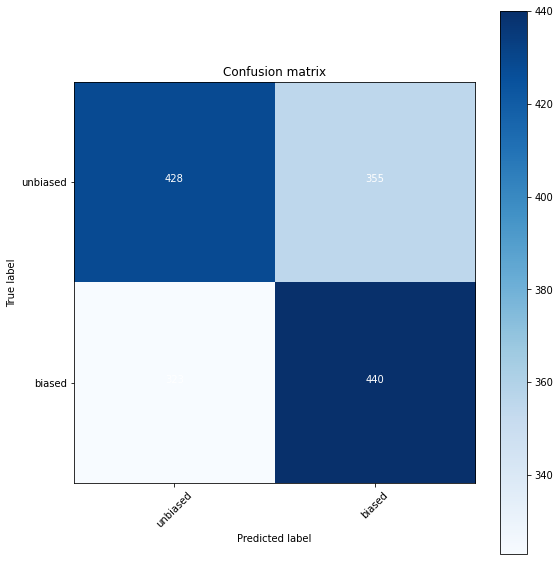

In [31]:
labels = test_tokenized['label']
preds = F.softmax(preds,dim=1).argmax(dim=1)

cm = confusion_matrix(labels,preds.cpu())
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm,['unbiased','biased'])

In [33]:
1500-(428+440+355)

277